[*********************100%%**********************]  1 of 1 completed


,Description,Value
0,Session id,42
1,Target,Next_Close
2,Target type,Regression
3,Original data shape,"(3046, 8)"
4,Transformed data shape,"(3046, 8)"
5,Transformed train set shape,"(2436, 8)"
6,Transformed test set shape,"(610, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.7574,27.1057,5.0955,0.9900,0.0852,0.0510,0.4650
rf,Random Forest Regressor,3.1304,106.1653,8.7236,0.9632,0.1039,0.0537,1.2010
dt,Decision Tree Regressor,3.4268,176.2774,11.7695,0.9388,0.1467,0.0555,0.0330
xgboost,Extreme Gradient Boosting,3.3584,48.9465,6.8808,0.9820,0.1021,0.0596,0.1500
lightgbm,Light Gradient Boosting Machine,4.0582,72.5199,8.2916,0.9727,0.1231,0.0776,1.2750
gbr,Gradient Boosting Regressor,7.4668,147.7956,11.8628,0.9469,0.1812,0.1428,0.6470
huber,Huber Regressor,26.9829,2235.6469,47.0280,0.1691,0.5784,0.3939,0.0350
ada,AdaBoost Regressor,16.5576,492.7358,22.0606,0.8132,0.3872,0.4018,0.2000
knn,K Neighbors Regressor,30.4164,1984.4196,44.3557,0.2635,0.5446,0.5481,0.0270
lasso,Lasso Regression,25.6969,1579.5398,39.4683,0.4212,0.5366,0.5524,0.0550


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Best model is ExtraTreesRegressor(n_jobs=-1, random_state=42)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.3777,17.8101,4.2202,0.9929,0.0890,0.0512


 % Errors does not look normally distributed (reject H0) according to Shapiro-Wilk Test


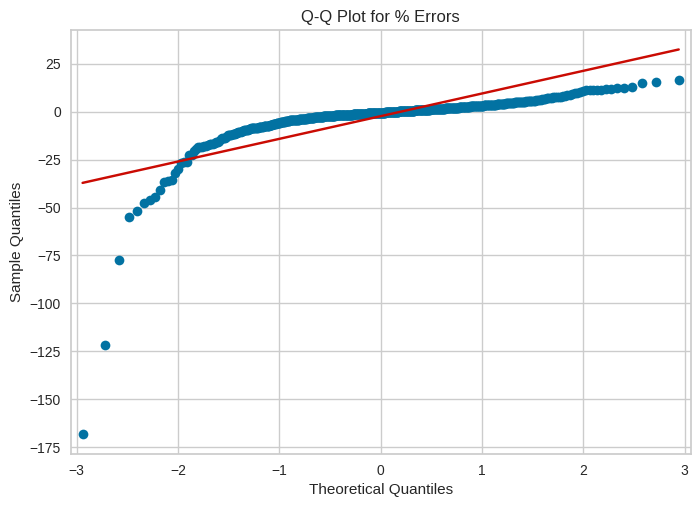

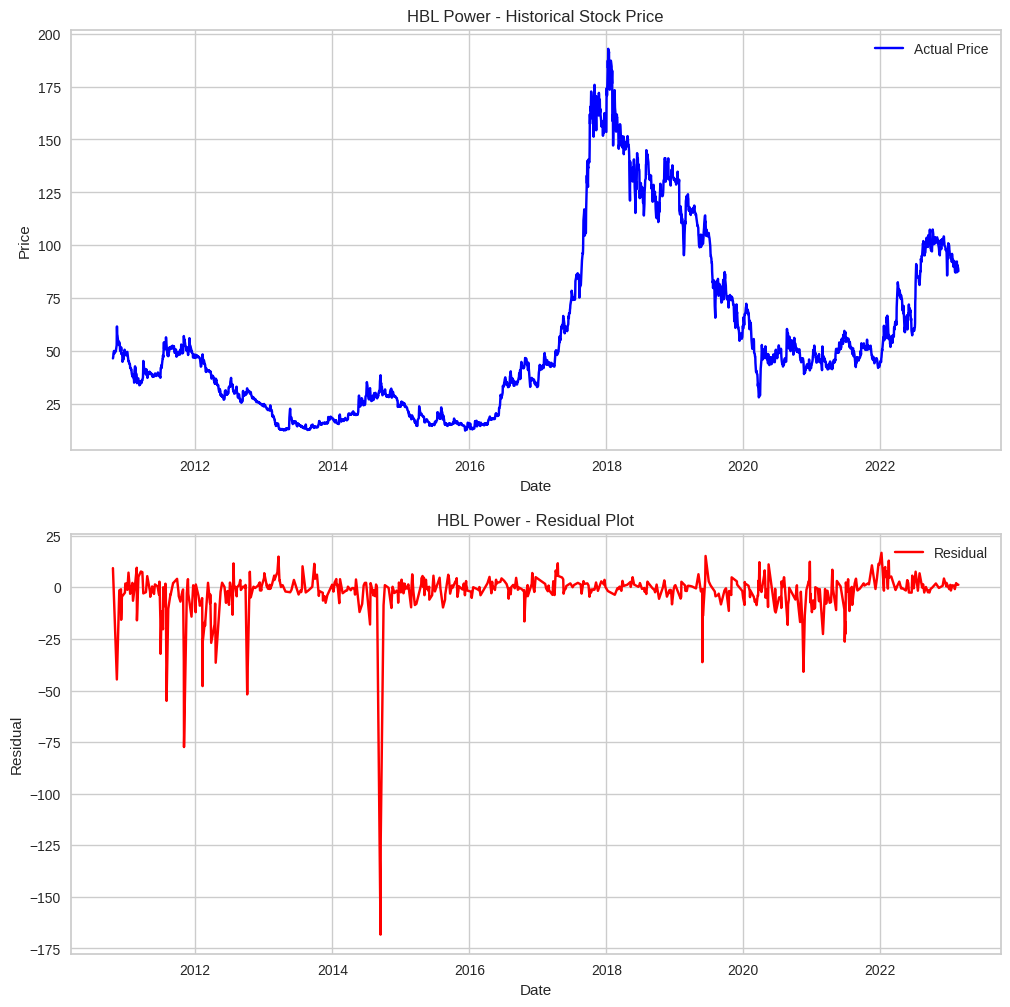

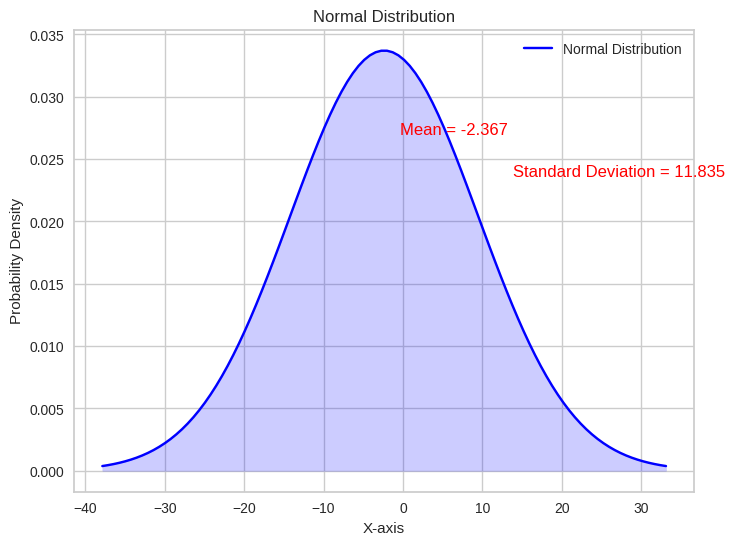

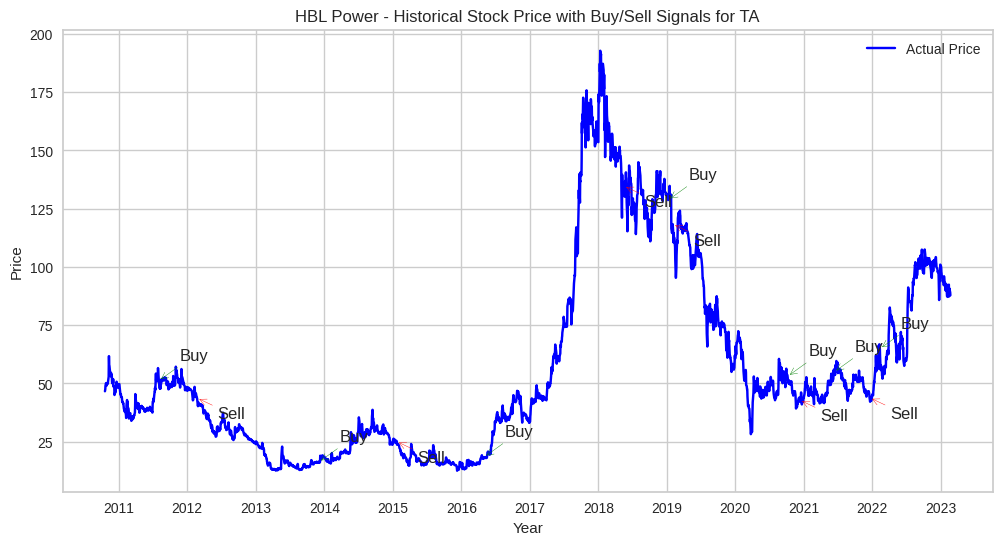

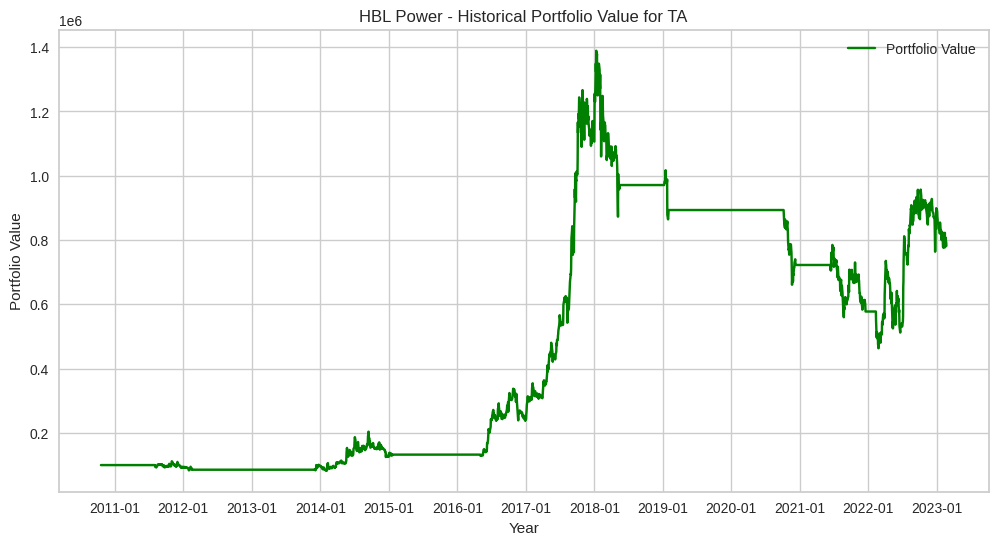

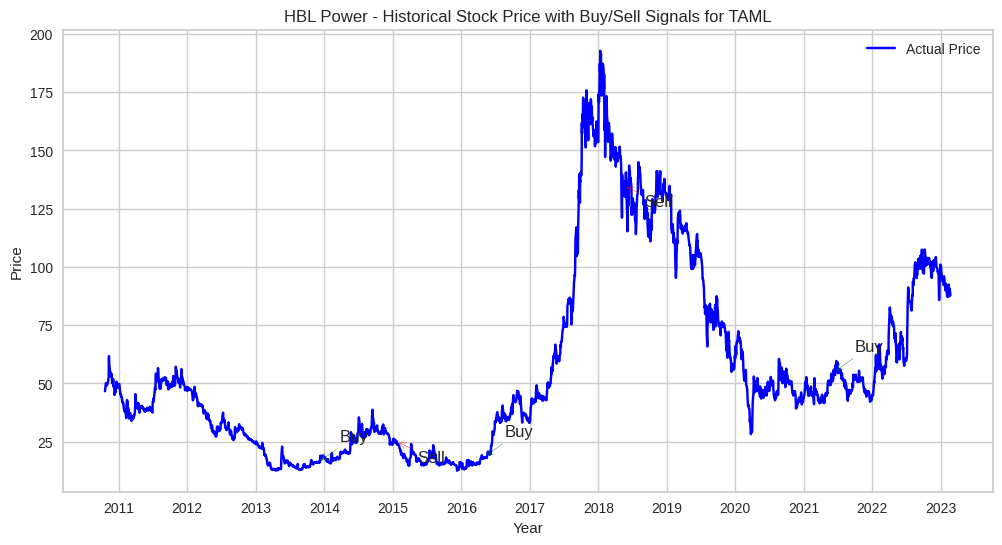

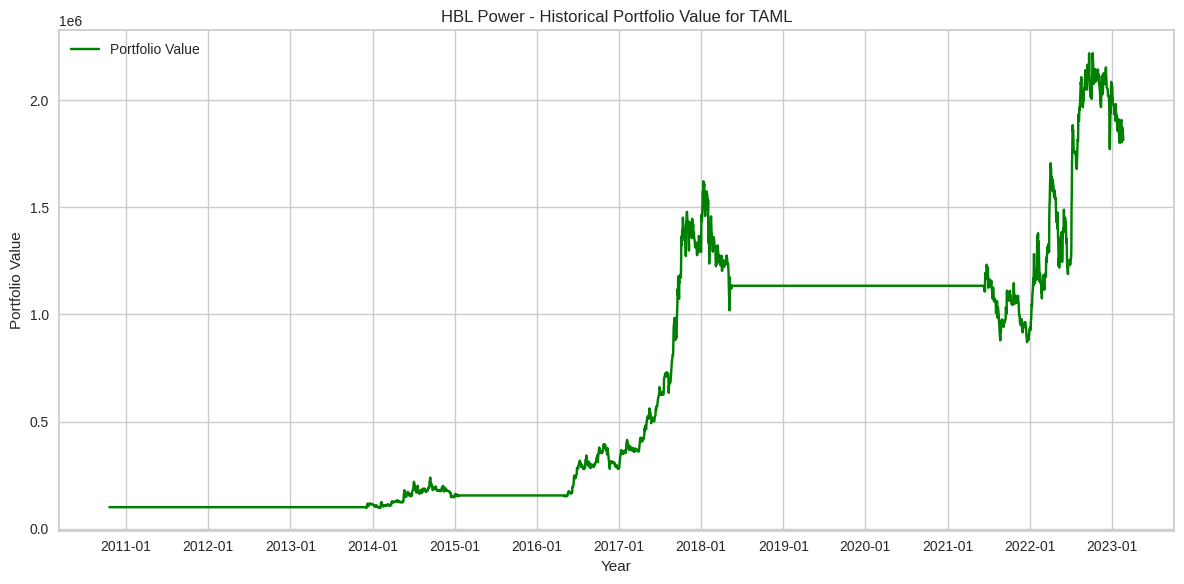

Total run time: 83.5996 seconds


In [3]:
# Import required libraries

import pandas as pd
import numpy as np
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.stats import shapiro
from pycaret.regression import *
import matplotlib.dates as mdates
import matplotlib.patches as patches

def main():

    # Record the start time
    start_time = time.time()

    # List of the top 20 Nifty 50 stocks with their ticker symbols
    top_20_nifty50 = [
        {"Stock": "HBL Power", "Ticker": "HSCL.NS"},
   ]

    # Loop through the list of top 20 stocks and perform the analysis

    for stock_info in top_20_nifty50:

      Analysis(stock_info, start_date="2010-01-01", end_date="2050-01-01")

    plt.tight_layout()
    plt.show()
    # Record the end time
    end_time = time.time()
    # Calculate the total run time
    total_time = end_time - start_time
    print(f"Total run time: {total_time:.4f} seconds")

# Function to calculate and plot for a stock

def Analysis(stock_info, start_date, end_date):
    stock_name = stock_info["Stock"]
    ticker = stock_info["Ticker"]

    # Download historical stock price data
    data = yf.download(ticker, start=start_date, end=end_date)
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()

    # Create lag features for the target variable (Close price)
    data['Next_Close'] = data['Close'].shift(-200)
    data.dropna(inplace=True)

   # print(data.iloc[-1])

    # Define features and target variable
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_50', 'SMA_200']
    X = data[features]
    y = data['Next_Close']
    new_data = X
    new_data['Next_Close'] = y

    # Find best ML Model for prediction
    best_model = ML_Algo_pred(new_data)
    # Backtest ML Model
    backtesting_ML_model (data, stock_name, best_model, X, y)
    # Generate Signals based on Technical Analysis
    buy_signal, sell_signal, portfolio_value, portfolio_dates = generate_signals_TA(data, stock_name, best_model, features)
    # Plot Signals based on Technical Analysis
    plot_signals ('TA', data, stock_name, buy_signal, sell_signal, portfolio_value, portfolio_dates)
    # Generate Signals based on Technical Analysis and ML model input
    buy_signal, sell_signal, portfolio_value, portfolio_dates = generate_signals_TAML(data, stock_name, best_model, features)
    # Plot Signals based on Technical Analysis
    plot_signals ('TAML', data, stock_name, buy_signal, sell_signal, portfolio_value, portfolio_dates)

# Function to generate buy/sell signal and caculate portfolio value for TA
def generate_signals_TA(data, stock_name, best_model, features):
    # Initialize lists to store buy and sell signals
    buy_signal = []
    sell_signal = []

    # Initialize variables for buy and sell signals and profit tracking
    position = 0  # 0 represents no position, 1 represents a long position
    initial_cash = 100000  # Initial cash for tracking profit
    cash = initial_cash
    shares_held = 0
    portfolio_value = [initial_cash]  # Start with initial cash
    portfolio_dates = [data.index[0]]  # Initialize with the first date

    # Calculate buy and sell signals based on the Golden Cross and Death Cross
    for i in range(1, len(data)):

        if data['SMA_50'].iloc[i - 1] < data['SMA_200'].iloc[i - 1] and data['SMA_50'].iloc[i] >= data['SMA_200'].iloc[i] :
            if position == 0:  # If not in a position, buy with available cash
                buy_signal.append(data.index[i])
                shares_held = cash / data['Close'].iloc[i]
                cash = 0
                position = 1
        elif data['SMA_50'].iloc[i - 1] > data['SMA_200'].iloc[i - 1] and data['SMA_50'].iloc[i] <= data['SMA_200'].iloc[i] :
            if position == 1:  # If in a position, sell all shares
                sell_signal.append(data.index[i])
                cash = shares_held * data['Close'].iloc[i]
                shares_held = 0
                position = 0

        # Calculate portfolio value and append to the list
        portfolio_value.append(cash + shares_held * data['Close'].iloc[i])
        portfolio_dates.append(data.index[i])

        # print(f"buy signal data for {stock_name} => {buy_signal} ")
        # print(f"sell signal data for {stock_name} => {sell_signal}  ")
        # print(f"portfolio value data for {stock_name} => {portfolio_value} ")

    return buy_signal, sell_signal, portfolio_value, portfolio_dates

# Function to generate buy/sell signal and caculate portfolio value for TA + ML
def generate_signals_TAML(data, stock_name, best_model, features):
    # Initialize lists to store buy and sell signals
    buy_signal = []
    sell_signal = []

    # Initialize variables for buy and sell signals and profit tracking
    position = 0  # 0 represents no position, 1 represents a long position
    initial_cash = 100000  # Initial cash for tracking profit
    cash = initial_cash
    shares_held = 0
    portfolio_value = [initial_cash]  # Start with initial cash
    portfolio_dates = [data.index[0]]  # Initialize with the first date

    # Make predictions using best ML model
    X = data[features]
    y_pred = predict_model(best_model, data=X)

    # Calculate buy and sell signals based on the Golden Cross and Death Cross
    for i in range(1, len(data)):

        # Make a prediction on signal date using single record
        # X = data[features].iloc[i]
        # y_pred = predict_model(best_model, data=X.to_frame().T)['prediction_label'].values[0]

        if data['SMA_50'].iloc[i - 1] < data['SMA_200'].iloc[i - 1] and data['SMA_50'].iloc[i] >= data['SMA_200'].iloc[i] and y_pred['prediction_label'].values[i] > data['Close'].iloc[i]:
            if position == 0:  # If not in a position, buy with available cash
                buy_signal.append(data.index[i])
                shares_held = cash / data['Close'].iloc[i]
                cash = 0
                position = 1
        elif data['SMA_50'].iloc[i - 1] > data['SMA_200'].iloc[i - 1] and data['SMA_50'].iloc[i] <= data['SMA_200'].iloc[i] and y_pred['prediction_label'].values[i] < data['Close'].iloc[i]:
            if position == 1:  # If in a position, sell all shares
                sell_signal.append(data.index[i])
                cash = shares_held * data['Close'].iloc[i]
                shares_held = 0
                position = 0

        # Calculate portfolio value and append to the list
        portfolio_value.append(cash + shares_held * data['Close'].iloc[i])
        portfolio_dates.append(data.index[i])

        # print(f"buy signal data for {stock_name} => {buy_signal} ")
        # print(f"sell signal data for {stock_name} => {sell_signal}  ")
        # print(f"portfolio value data for {stock_name} => {portfolio_value} ")

    return buy_signal, sell_signal, portfolio_value, portfolio_dates

# Function to select best ML prediction model
def ML_Algo_pred(new_data):

    # Initialize PyCaret regression setup
    setup(data=new_data, target='Next_Close', train_size=0.8, session_id=42)

    # Compare multiple regression models and evaluate them
    best_model = compare_models(fold=10, sort='MAPE')

    # Print the best model and its parameters
    print(f"Best model is {best_model}")

    return best_model


# Backtesting best ML prediction model
def backtesting_ML_model (data, stock_name, best_model, X, y):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Make predictions on the test set
    y_pred = predict_model(best_model, data=X_test)
    #print(y_pred)

    # Create a DataFrame to store residuals
    residuals = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred['prediction_label'], 'Residual': ((y_test - y_pred['prediction_label'])/y_test)*100}).sort_index()
    error_df = ((y_test - y_pred['prediction_label'])/y_test)*100
    error_df_mean = error_df.mean()
    error_df_std = error_df.std()

    # Test of Normality of errors
    # Shapiro-Wilk Test
    stat, p = shapiro(error_df)
    alpha = 0.2  # Significance level
    if p > alpha:
        print(' % Errors looks normally distributed (fail to reject H0) according to Shapiro-Wilk Test')
    else:
        print(' % Errors does not look normally distributed (reject H0) according to Shapiro-Wilk Test')
    # Q-Q Plot
    sm.qqplot(error_df, line='s')
    plt.title('Q-Q Plot for % Errors')
    plt.show()

    # Generate a range of values to represent the x-axis
    x = np.linspace(error_df_mean - 3 * error_df_std, error_df_mean + 3 * error_df_std, 100)

    # Calculate the probability density function (PDF) values for the normal distribution
    pdf = norm.pdf(x, loc=error_df_mean, scale=error_df_std)

    # Create two subplots, one below the other
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

    # Plot the historical stock price movement in the first subplot
    axes[0].plot(data.index, data['Close'], label='Actual Price', color='blue')
    axes[0].legend()
    axes[0].set_title(f'{stock_name} - Historical Stock Price')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Price')

    # Plot the residuals in the second subplot
    axes[1].plot(residuals.index, residuals['Residual'], label='Residual', color='red')
    axes[1].legend()
    axes[1].set_title(f'{stock_name} - Residual Plot')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Residual')

    # Plot the normal distribution
    plt.figure(figsize=(8, 6))
    plt.plot(x, pdf, color='blue', label='Normal Distribution')
    plt.fill_between(x, pdf, color='blue', alpha=0.2)
    # Add labels for mean and standard deviation
    plt.annotate(f'Mean = {round(error_df_mean,3)}', xy=(round(error_df_mean,3), pdf.max() * 0.8), xytext=(round(error_df_mean,3) + 2, pdf.max() * 0.8), fontsize=12,
             color='red')
    plt.annotate(f'Standard Deviation = {round(error_df_std,3)}', xy=(error_df_std, pdf.max() * 0.7), xytext=(error_df_std + 2, pdf.max() * 0.7), fontsize=12,
             color='red')
    plt.title('Normal Distribution')
    plt.xlabel('X-axis')
    plt.ylabel('Probability Density')
    plt.grid(True)
    plt.legend()
    plt.show()

# Function to plot buy/sell signal and caculate portfolio value
def plot_signals (Algo, data, stock_name, buy_signal, sell_signal, portfolio_value, portfolio_dates):
    # Extract unique years from data.index
    # years = [timestamp.year for timestamp in data.index]
    #print(data.index)
    #print(years)
    # Plot buy and sell signals on the price chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data.index, data['Close'], label='Actual Price', color='blue')

    # Customize the x-axis to display only the year
    n = 1  # Adjust 'n' to your preference (e.g., 5 years)
    year_locator = mdates.YearLocator(base=n)
    ax.xaxis.set_major_locator(year_locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the tick labels as years


    # Plot buy signals with green up arrows if they exist
    if buy_signal and len(buy_signal) > 0:
        for signal in buy_signal:
            if signal in data.index:
                buy_x = mdates.date2num(signal)
                ax.annotate('Buy', (buy_x, data['Close'].loc[signal]), xytext=(15, 15),
                            textcoords='offset points', arrowprops=dict(arrowstyle="->", color='green'))

    # Plot sell signals with red down arrows if they exist
    if sell_signal and len(sell_signal) > 0:
        for signal in sell_signal:
            if signal in data.index:
                sell_x = mdates.date2num(signal)
                ax.annotate('Sell', (sell_x, data['Close'].loc[signal]), xytext=(15, -15),
                            textcoords='offset points', arrowprops=dict(arrowstyle="->", color='red'))

    plt.title(f'{stock_name} - Historical Stock Price with Buy/Sell Signals for {Algo}')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.legend()

    # Plot historical profit
    # years = [timestamp.year for timestamp in data.index]
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot portfolio value over time (entire list)
    ax.plot(portfolio_dates, portfolio_value, label='Portfolio Value', color='green')
    # Customize the x-axis to display only the year
    n = 1  # Adjust 'n' to your preference (e.g., 5 years)
    year_locator = mdates.YearLocator(base=n)
    ax.xaxis.set_major_locator(year_locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.title(f'{stock_name} - Historical Portfolio Value for {Algo}')
    plt.xlabel('Year')
    plt.ylabel('Portfolio Value')
    plt.legend()

main()